# Import Library

In [1]:
# Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os

2024-12-09 01:37:21.741855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 01:37:22.228233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 01:37:22.604638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733708242.873278   40919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733708242.964852   40919 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 01:37:23.847665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Prepare Dataset

In [2]:
# Path to dataset
dataset_path = '/home/jupyter/Dental_diseases_Model'

In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% data for validation
)

In [8]:
counter = 0
dir_names=['Caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'Random']
for file in (dir_names):
    dir = os.listdir(f"{dataset_path}/{file}")

    print(f"Data for {file} is {len(dir)}")

Data for Caries is 2382
Data for Gingivitis is 2349
Data for Mouth Ulcer is 2541
Data for Tooth Discoloration is 1834
Data for Random is 2047


# Modelling

## Use Transfer Learning MobileNetV2

In [9]:
# Make generator for train and validation
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Pict Resolution MobileNetV2
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 8924 images belonging to 5 classes.
Found 2228 images belonging to 5 classes.


In [10]:
# Load Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze petrained layer for transfer learning

In [11]:
# model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), 
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for reduce overfitting
    Dense(5, activation='softmax')  # 5 classes ['Caries', 'Gingivitis', 'Mouth Ulcer', 'Random', 'Tooth Discoloration']
])

In [12]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/home/jupyter/Checkpoint/Best_Dental_Model.keras', # Changed the file extension to .keras
    monitor='val_loss',
    save_best_only=True
)

In [14]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
279/279 [==============================] - 135s 477ms/step - loss: 0.6425 - accuracy: 0.7510 - val_loss: 0.4269 - val_accuracy: 0.8474
Epoch 2/20
279/279 [==============================] - 121s 434ms/step - loss: 0.4139 - accuracy: 0.8383 - val_loss: 0.3538 - val_accuracy: 0.8743
Epoch 3/20
279/279 [==============================] - 118s 421ms/step - loss: 0.3616 - accuracy: 0.8595 - val_loss: 0.3191 - val_accuracy: 0.8820
Epoch 4/20
279/279 [==============================] - 118s 421ms/step - loss: 0.3113 - accuracy: 0.8802 - val_loss: 0.2923 - val_accuracy: 0.8918
Epoch 5/20
279/279 [==============================] - 117s 420ms/step - loss: 0.2787 - accuracy: 0.8957 - val_loss: 0.2491 - val_accuracy: 0.9107
Epoch 6/20
279/279 [==============================] - 118s 421ms/step - loss: 0.2762 - accuracy: 0.8911 - val_loss: 0.2428 - val_accuracy: 0.9120
Epoch 7/20
279/279 [==============================] - 119s 428ms/step - loss: 0.2472 - accuracy: 0.9097 - val_loss: 0.2790 -

In [15]:
# Evaluasi model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

70/70 [==============================] - 25s 349ms/step - loss: 0.1648 - accuracy: 0.9439
Validation Accuracy: 94.39%


# Save Model

In [22]:
# Save final model
model.save('/home/jupyter/H5/Final3_Dental_MobileNet_Model.h5')

In [23]:
# Save history train model
import pickle
with open('/home/jupyter/H5/Final3_Dental_MobileNet_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Plot Training and Validation

In [25]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training vs Validation Loss')

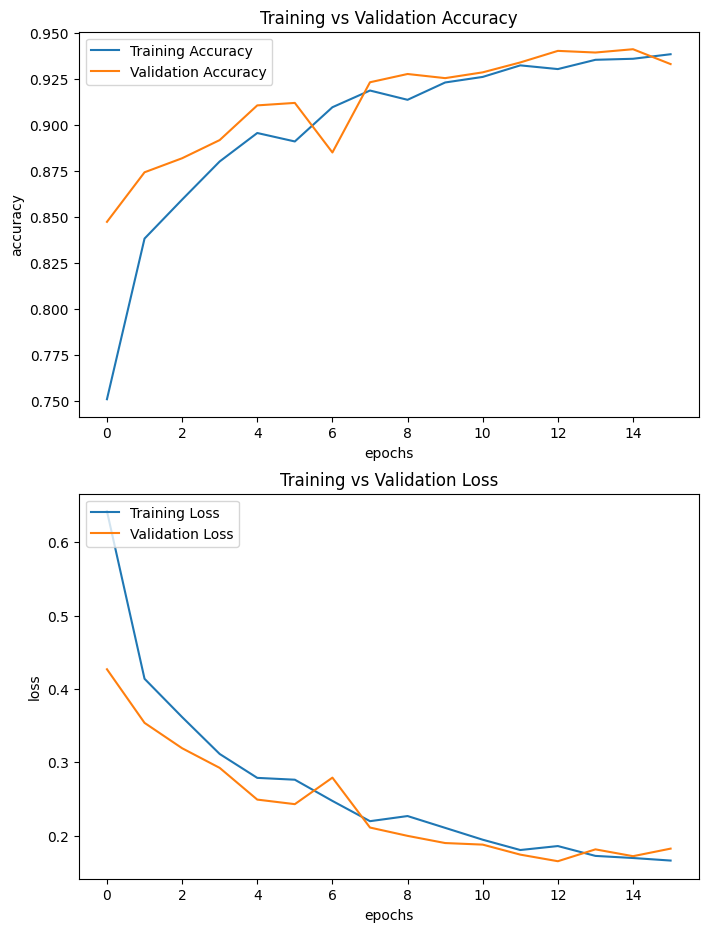

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 11))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper left')
plt.title('Training vs Validation Loss')

# Test Model

In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [28]:
# Path model yang telah disimpan
model_path = '/home/jupyter/H5/Final3_Dental_MobileNet_Model.h5'
model = load_model(model_path)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2,422,597
Trainable params: 164,613
Non-tr

In [30]:
# Compile ulang model (opsional, jika diperlukan untuk evaluasi atau pelatihan lebih lanjut)
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
model.evaluate(val_generator)

70/70 [==============================] - 26s 352ms/step - loss: 0.1671 - accuracy: 0.9336


[0.16708703339099884, 0.9335727095603943]

## Test with image

In [33]:
# Path ke gambar baru
image_path = '/home/jupyter/coba/ulcer.jpeg'

# Preprocessing gambar
img = image.load_img(image_path, target_size=(224, 224))  # Ukuran sesuai input model
img_array = image.img_to_array(img) / 255.0  # Normalisasi nilai piksel
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

In [34]:
# Load class indices dari training generator
dataset_path = '/home/jupyter/Dental_diseases_Model'

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generator untuk mendapatkan mapping class indices
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

class_indices = train_generator.class_indices
classes = list(class_indices.keys())  # Nama kelas
print(train_generator.class_indices)

Found 8924 images belonging to 5 classes.
{'Caries': 0, 'Gingivitis': 1, 'Mouth Ulcer': 2, 'Random': 3, 'Tooth Discoloration': 4}


In [36]:
# Prediksi
predictions = model.predict(img_array)

1/1 [==============================] - 1s 625ms/step


In [37]:
# Mendapatkan kelas prediksi dan confidence
predicted_class = classes[np.argmax(predictions)]  # Nama kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Confidence untuk kelas prediksi

In [38]:
# Output hasil prediksi
if predicted_class == "Random":
    print("Bad Request: Gambar tidak terkait dengan gigi.")
else:
    if confidence < 70:
        print(f"Sepertinya ada gigi anda lumayan sehat")
        print(f"Gigi terdiagnosis mengalami: {predicted_class} hanya")
    else :
        print(f"Gigi terdeteksi mengalami masalah: {predicted_class} dengan ")
        print(f"Confidence: {confidence:.2f}%")

Gigi terdeteksi mengalami masalah: Mouth Ulcer dengan 
Confidence: 99.76%


In [22]:
# #Tempat eksekusi
# # Path ke gambar baru Taruh di coba/
# image_path = '/home/jupyter/coba/ulcer1.jpeg' #pastikan format benar

# # Preprocessing gambar
# img = image.load_img(image_path, target_size=(224, 224))  # Ukuran sesuai input model
# img_array = image.img_to_array(img) / 255.0  # Normalisasi nilai piksel
# img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
# # Prediksi
# predictions = model.predict(img_array)
# # Mendapatkan kelas prediksi dan confidence
# predicted_class = classes[np.argmax(predictions)]  # Nama kelas dengan probabilitas tertinggi
# confidence = np.max(predictions) * 100  # Confidence untuk kelas prediksi
# # Output hasil prediksi
# if predicted_class == "Noise":
#     print("Bad Request: Gambar tidak terkait dengan gigi.")
# else:
#     if confidence < 70:
#         print(f"Sepertinya ada gigi anda lumayan sehat")
#         print(f"Gigi terdiagnosis mengalami: {predicted_class} hanya")
#     else :
#         print(f"Gigi terdeteksi mengalami masalah: {predicted_class} dengan ")
#         print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Gigi terdeteksi mengalami masalah: Mouth Ulcer dengan 
Confidence: 99.93%


# Deploy to TFJS

In [1]:
!pip install tensorflowjs

In [1]:
# # Save final to tfjs
# !tensorflowjs_converter --input_format=tf_saved_model \
#     --output_format=tfjs_graph_model \
#     /home/jupyter/SavedModel/ \
#     /home/jupyter/modelkujs/

2024-12-05 16:32:59.524652: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 16:32:59.527991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 16:32:59.537582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733416379.553001   40766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733416379.557422   40766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 16:32:59.575389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [19]:
# !tensorflowjs_converter --input_format=keras \
#     /home/jupyter/H5/Final1_Dental_Model.h5 \
#     /home/jupyter/modelh5tf

/bin/bash: line 1: tensorflowjs_converter: command not found


In [2]:
# model.save("/home/jupyter/savedmodel")

NameError: name 'model' is not defined

In [11]:
# !tensorflowjs_converter \
#     --input_format=tf_saved_model \
#     --saved_model_tags=serve \
#     /home/jupyter/H5/Final3_Dental_MobileNet_Model.h5 \
#     /home/jupyter/modelsvtf2

2024-12-27 16:33:53.205650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735317233.220612   44236 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735317233.224840   44236 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/opt/conda/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/opt/conda/lib/python3.10/site-package

In [16]:
!tensorflowjs_converter --input_format=keras /home/jupyter/H5/Final3_Dental_MobileNet_Model.h5 ./tfjs

2024-12-27 16:43:13.142617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735317793.157086   45913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735317793.161288   45913 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


In [19]:
!tensorflowjs_converter \
    --input_format=keras \
    /home/jupyter/H5/Final3_Dental_MobileNet_Model.h5 \
    /home/jupyter/tfjs2

2024-12-27 16:48:26.568215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735318106.583474   47484 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735318106.587731   47484 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


# Deploy to TFLite

In [39]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /var/tmp/tmpxarqiu2u/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpxarqiu2u/assets
2024-12-08 16:08:08.756432: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-08 16:08:08.756488: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-12-08 16:08:08.757615: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/tmp/tmpxarqiu2u
2024-12-08 16:08:08.780661: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-12-08 16:08:08.780725: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/tmp/tmpxarqiu2u
2024-12-08 16:08:08.851753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-12-08 16:08:08.885780: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-12-08 16:08:09.298334: I tensorflow/cc/saved_model/loader.cc:213] Running i

In [40]:
tflite_name = 'tf_lite_model_Final3_Dental_MobileNet_Model.tflite'

with open(tflite_name, 'wb') as f:
    f.write(tflite_model)

# Load and Test Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [6]:
model_path = '/home/jupyter/H5/Final3_Dental_MobileNet_Model.h5'
model = load_model(model_path)

TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

In [5]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import h5py

with h5py.File('/home/jupyter/H5/Final3_Dental_MobileNet_Model.h5', 'r') as f:
    print(list(f.keys()))

['model_weights', 'optimizer_weights']


In [8]:
from tensorflow.keras.models import model_from_json, load_model

# Load the model's JSON configuration
with open('/home/jupyter/modelsvtf/model.json', 'r') as f:
    model_config = f.read()

# Adjust the configuration
import json
config = json.loads(model_config)
for layer in config['config']['layers']:
    if layer['class_name'] == 'DepthwiseConv2D':
        layer['config'].pop('groups', None)

# Save modified configuration
with open('/home/jupyter/modelsvtf/updated_model_config.json', 'w') as f:
    json.dump(config, f)

# Load the model
with open('/home/jupyter/modelsvtf/updated_model_config.json', 'r') as f:
    updated_config = f.read()

model = model_from_json(updated_config)

# Load weights
model.load_weights('/home/jupyter/H5/Final3_Dental_MobileNet_Model.h5')

KeyError: 'config'